# Lab 1: Gaia, RR Lyrae stars, and Galactic Dust
### Due 4pm, Friday March 5, 2021
Jacqueline Telson

## Install & Import Necessary Packages

In [1]:
# Astroquery is needed to combine ADQL queries with Python code
#!pip install astroquery (uncomment this line if your computer does not already have astroquery installed)
from astroquery.utils.tap.core import TapPlus

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

## #1
Select top 100 rows from gaiadr2.vari_rrlyrae catalog where fundamental pulsation frequency (pf) has been measured and more than 40 clean epochs were obtained in the G band.

In [2]:
# Set up Caching System
from joblib import Memory
cachedir = './joblib_cache'
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

# load gaia server
from astroquery.gaia import Gaia

@memory.cache
def get_gaia_query(q):
    job = Gaia.launch_job(q)
    return job.get_results()

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
q = "SELECT TOP 100 * \
FROM gaiadr2.vari_rrlyrae \
WHERE pf != 0 \
AND num_clean_epochs_g >40"

query = get_gaia_query(q)

In [4]:
query[0:10]

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object
369295551293819386,5866125710834119808,0.45207240076998667,1.3003196171988113e-06,--,--,--,--,--,--,1700.6320136814795,1.8389296380623503e-06,1783.0270727437294,1.8389296380623503e-06,1783.019968286169,1.8389296380623503e-06,19.829002378100697,0.0017611118938539022,20.05887749491192,0.055322172004415006,18.142943674742085,0.00980144855856893,0.6108646433568055,0.010067274726763064,0.5065093441972692,0.2519379630043119,0.03224426272644365,0.060876173636291726,--,--,0.5597453419602187,0.01980461486583596,--,--,3.4572796602163507,0.04746986161849459,--,--,57,17,16,6.536679457310559,0.0873667746655819,RRab
369295551293819386,5978435871487788288,0.648442595496394,1.3470624322336533e-06,--,--,--,--,--,--,1709.290949398965,1.9050339610281209e-06,1709.3140540338713,1.9050339610281209e-06,1709.3121406809541,1.9050339610281209e-06,18.37905582817158,0.0006249688617317147,19.477055011641482,0.015789720173731918,17.15073891619941,0.007089873749929578,0.48610466902325555,0.0033637645178221307,0.5504655470455546,0.07245157079537685,0.25297190255184177,0.02761626747777527,-0.04347318266439615,0.21938697428693577,0.46211654418447684,0.008444382809350011,0.2652076445305246,0.007413715850295902,4.565746788759661,0.02263850113372803,3.151089820159477,0.033069106819820455,41,35,32,3.6473370781995142,0.06448844234447489,RRab
369295551293819386,5704736782734774528,0.6270046382069818,2.9805914933406168e-06,--,--,--,--,--,--,1762.1223170527178,4.215192913776177e-06,1762.1189367162933,4.215192913776177e-06,1762.3000815733121,4.215192913776177e-06,18.367183031320444,0.000554359615774292,18.508340417630986,0.004206101573781567,18.009453610798094,0.005351562385562215,0.3653407502087944,0.0020185600813135713,0.37852292089716855,0.019769325593019194,0.17414816631826113,0.02849018063584878,--,--,--,--,--,--,--,--,--,--,44,37,34,--,--,RRab
369295551293819386,5816755332315333888,0.7913965498561393,1.5092189854296103e-06,--,--,--,--,--,--,1703.9974761976036,2.1343579577855177e-06,1704.0167528948207,2.1343579577855177e-06,1704.0430912518177,2.1343579577855177e-06,17.585120849505195,0.0003669927387024788,17.894023067042163,0.0019130044814337321,17.083056145932968,0.002077515536999311,0.4801964780016412,0.0017617249265559454,0.5403224127139836,0.013485703925518205,0.3496465663698096,0.010182531120406948,-0.38174293640950197,0.21916524180764185,0.4221742759106887,0.0034878987822288443,0.21975978846114191,0.003453219779328249,4.460737439139983,0.01148835315771656,3.0009840648164285,0.016616872447630462,68,65,61,0.334260602939929,0.051369448434517836,RRab
369295551293819386,5821611776409134976,0.7982343357378148,1.349458892612425e-06,--,--,--,--,--,--,1702.5290893966207,1.90842306779747e-06,1702.514925327494,1.90842306779747e-06,1702.5339602708698,1.90842306779747e-06,16.457312500364054,0.00019430738023192256,16.73802747970098,0.0012066558508083242,15.995031964185294,0.0014031686149913482,0.44558736648837893,0.0012549092356595821,0.55281

## #2
I downloaded 100 files containing the light curves for each source. Below, I plot the light curve for the first source in the data set.

In [5]:
light_curve = pd.read_csv('anonymous1613329577203/EPOCH_PHOTOMETRY-Gaia DR2 '+str(5866125710834119808)+'.csv')
light_curve

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,5866125710834119808,16871156997575855,G,1701.949353,19.477046,305.160078,10.351194,29.480665,False,False,4103,369295551293819386
1,5866125710834119808,16875249299403399,G,1702.023355,19.490792,301.321201,5.423950,55.553833,False,False,1,369295551293819386
2,5866125710834119808,18799460942635593,G,1736.819380,20.006613,187.370484,14.374172,13.035219,False,False,8355841,369295551293819386
3,5866125710834119808,21385141519295611,G,1783.578907,19.881292,210.295345,14.664467,14.340470,False,False,8355841,369295551293819386
4,5866125710834119808,21408715614860113,G,1784.005234,20.063027,177.883450,14.072553,12.640453,False,False,8355841,369295551293819386
...,...,...,...,...,...,...,...,...,...,...,...,...
89,5866125710834119808,50934209374852305,RP,2317.967533,18.139965,445.432639,40.595603,10.972436,False,False,0,369295551293819386
90,5866125710834119808,50948042365083925,RP,2318.217700,18.098200,462.900971,39.147049,11.824671,False,False,0,369295551293819386
91,5866125710834119808,50952134637961979,RP,2318.291709,18.179895,429.348530,35.078087,12.239793,False,False,0,369295551293819386
92,5866125710834119808,50961875455853740,RP,2318.467868,18.015578,499.501606,41.019389,12.177207,False,False,0,369295551293819386


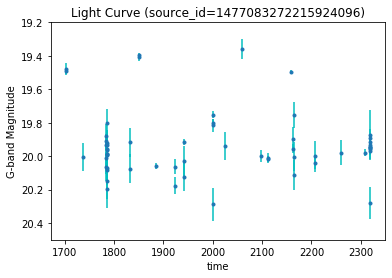

In [6]:
light_curve = light_curve[light_curve['band'] == 'G'] #select only for G-band rows
magnitude_error = 1.09/(light_curve['flux_over_error']) # formula from http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/stats/L18/index.html

#plot magnitude vs. time
plt.errorbar(light_curve['time'], light_curve['mag'], yerr = magnitude_error, fmt=".", ecolor='c')
plt.xlabel('time')
plt.ylabel('G-band Magnitude')
plt.title('Light Curve (source_id=1477083272215924096)')
plt.ylim(20.5, 19.2)
plt.show()

## #3 
Estimate the period and mean G-band magnitude of the 100 light curves I downloaded above.

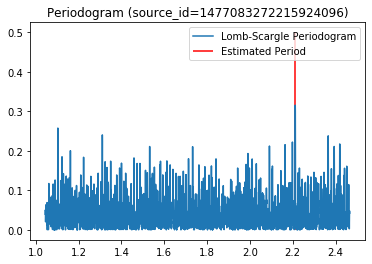

Estimated Period: 0.45212602135003943 days


In [7]:
# find min and max frequencies in data set
fmin = 1/np.max(query['pf'])
fmax = 1/np.min(query['pf'])

# create Lomb-Scargle Periodogram
frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(nyquist_factor=15, 
                                                                                  minimum_frequency=fmin, maximum_frequency=fmax)
# plot Periodogram
plt.plot(frequency, power, label='Lomb-Scargle Periodogram') 

# identify estimated period by finding frequency with largest power
period = 1/frequency[np.argmax(power)]
plt.vlines(1/period, 0, 0.5, 'r', label = 'Estimated Period')

plt.legend()
plt.title('Periodogram (source_id=1477083272215924096)')
plt.show()

print('Estimated Period:', period, 'days')

In [8]:
# define magnitude - flux transformation functions necessary to estimate mean magnitude
def mag_to_flux(mag):
    return 10**(-mag/2.5)

def flux_to_mag(flux):
    return -2.5*np.log10(flux)

In [9]:
# calculate the mean magnitude by converting to flux, getting the mean flux, then converting back to magnitude
flux_mean = np.mean(mag_to_flux(light_curve['mag']))
mag_mean = flux_to_mag(flux_mean)

print('Estimated Mean G-band Magnitude (source_id=1477083272215924096):', mag_mean)

Estimated Mean G-band Magnitude (source_id=1477083272215924096): 19.909572223987308


In [10]:
# estimate the period and mean magnitude for all 100 light curves
estimated_periods = []
estimated_mean_mags = []
for source_id in query['source_id']:
    light_curve = pd.read_csv('anonymous1613329577203/EPOCH_PHOTOMETRY-Gaia DR2 '+str(source_id)+'.csv')
    frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(nyquist_factor=15, 
                                                                                  minimum_frequency=fmin, maximum_frequency=fmax)
    estimated_periods.append(1/frequency[np.argmax(power)])
    
    flux_mean = np.mean(mag_to_flux(light_curve['mag']))
    estimated_mean_mags.append(flux_to_mag(flux_mean))

## #4
Compare the periods I computed and the values reported in the catalog by calculating the Root Mean Squared Error between fundamental pulsation frequency and estimated periods.

In [11]:
rmse = np.sqrt(np.sum((query['pf']-estimated_periods)**2)/len(estimated_periods))
print('Error between reported periods and my estimated periods:', rmse)

Error between reported periods and my estimated periods: 0.06227706153182782


This error seems reasonably small and makes sense for natural error in the data. 
To get a better sense of how these values compare, I will plot the differences.

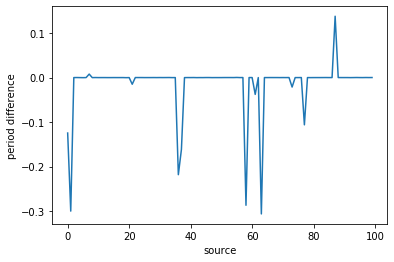

In [12]:
plt.plot(query['pf']-estimated_periods)
plt.xlabel('source')
plt.ylabel('period difference')
plt.show()

From this graph, it seems like for most of the sources the error is zero while for a few the error is larger, with a maximum absolute error of about 0.3

## #5

For the equation $f(t) = A_0 + \sum_{k=1}^K [a_k sin(kwt) + b_k cos(kwt)]$, when the period is unknown, there are $2K +2$ unknown variables. Once we estimate the period using the Lomb Scargle Periodogram, there are now $2K +1$ unknown variables. Nowe we can rewrite the function in the form of $y = X\beta$, where $\beta$ is a vector of the unknown parameters. Therefore, we can deconstruct $y$ as: 

$X = \begin{pmatrix}1 & 1 & ... & 1 & 1 & 1 & ... & 1 \\\ sin(wt_0) & sin(2wt_0) & ... & sin(kwt_0) & cos(wt_0) & cos(2wt_0) & ... & cos(kwt_0) \\\ sin(wt_1) & sin(2wt_1) & ... & sin(kwt_1) & cos(wt_1) & cos(2wt_1) & ... & cos(kwt_1) \\\ ... & ... & ... & ... & ... & ... & ... & ... \\\ sin(wt_n) & sin(2wt_n) & ... & sin(kwt_n) & cos(wt_n) & cos(2wt_n) & ... & cos(kwt_n) \end{pmatrix}$        $\beta = \begin{pmatrix}A_0 \\\ a_1 \\\ a_2 \\\ ... \\\ a_k \\\ b_1 \\\ b_2 \\\ ... \\\ b_k \end{pmatrix}$

## #6
For the star with Gaia DR2 id = 5813181197970338560, determine the series representations for K = 1, 3, 5, 7, and 9. Plot the phased light curve, the series representation on a fine grid, and the residuals between the data and series representation for each K.

In [13]:
query[6]

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object
369295551293819386,5813181197970338560,0.9576506522842548,2.9218694787229424e-07,--,--,--,--,--,--,1703.186659792172,4.132147444293991e-07,1703.1860262585833,4.132147444293991e-07,1703.1918151905295,4.132147444293991e-07,15.075666023070966,5.824257796191334e-05,15.318608339616892,0.0005924072862000843,14.641154207793663,0.00030192630874490464,0.6195616055656288,0.0005055757603992529,0.7610101678516124,0.005521480141471115,0.4650359261742434,0.003420129304852395,--,--,0.37070499038850246,0.0007500914611070431,0.29907193313231056,0.0007401404927273667,3.948367969218644,0.0026536860740495024,1.6486758740335237,0.002497036282800892,85,73,83,0.05589850894230958,0.05078346806008997,RRab


In [14]:
# read data from light curve file
light_curve = pd.read_csv('anonymous1613329577203/EPOCH_PHOTOMETRY-Gaia DR2 '+str(5813181197970338560)+'.csv')

# create Periodogram
frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(nyquist_factor=15, 
                                                                                  minimum_frequency=fmin, maximum_frequency=fmax)
# select only for G-band
light_curve = light_curve[light_curve['band'] == 'G']

# calculate period and angular frequency
P = 1/frequency[np.argmax(power)]
w = 2*np.pi/P

# get time and magnitude arrays
t = light_curve['time']
mag = light_curve['mag']

In [15]:
# use scipy.optimize.curve_fit to find beta vector of unknown parameters
from scipy.optimize import curve_fit

# define fourier fir function which returns the x data and the fitted y data
def fourier_fit(x, y, P, w, K):
    def fourier(x, *a):
        f = a[0]
        for k in range(1, K+1):
            f += a[k] * np.sin(k * w * x)
        for k, i in enumerate(range(K+1, 2*K+1)):
            f += a[k+K+1] * np.cos(k * w * x)
        return f
    popt, pcov = curve_fit(fourier, x, y, [1.0]*(2*K+1))
    return x , fourier(x, *popt)

In [16]:
# create pandas data frame which has a column corresponding to phase
df = pd.DataFrame({'mag': light_curve['mag'], 'flux': light_curve['flux'],'phase' : t % P, 'time' : light_curve['time']})
df = df.sort_values('phase')

Phased Light Curves Gaia DR2 5813181197970338560 for varying K values:


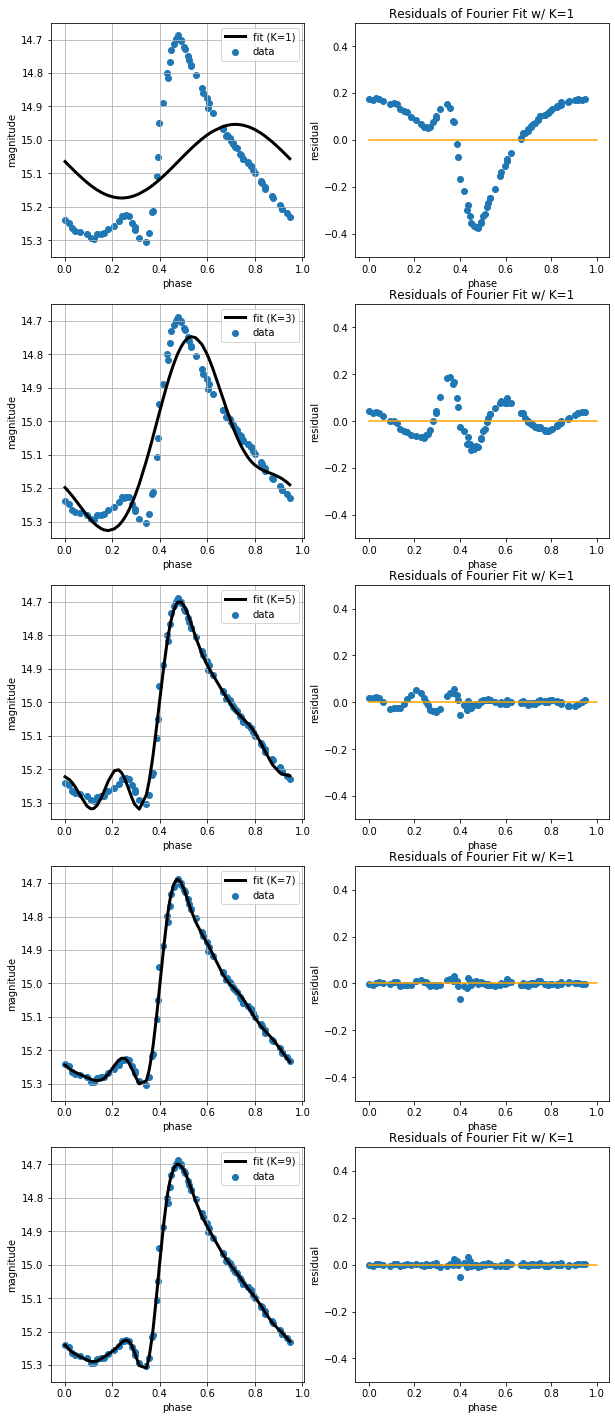

In [31]:
# plot series representations and residuals for each K
print('Phased Light Curves Gaia DR2 5813181197970338560 for varying K values:')

fig, ax = plt.subplots(5,2, figsize=(10,25))

i = 0
for K in [1,3,5,7,9]:
    x,y = fourier_fit(df['phase'], df['mag'], P, w, K)
    ax[i,0].plot(x,y, linewidth=3, color='k', label='fit (K='+str(K)+')')

    ax[i,0].scatter(df['phase'], df['mag'], label='data')
    ax[i,0].legend()
    #ax[i,0].set_title('Phased Light Curve Gaia DR2 5813181197970338560')
    ax[i,0].set(xlabel = 'phase', ylabel = 'magnitude')
    ax[i,0].grid()
    ax[i,0].set_ylim([15.35,14.65])
    
    ax[i,1].scatter(df['phase'], df['mag']-y)
    ax[i,1].plot([0,0], color='orange')
    ax[i,1].set_ylim([-0.5, 0.5])
    ax[i,1].set(xlabel = 'phase', ylabel = 'residual')
    ax[i,1].set_title('Residuals of Fourier Fit w/ K=1')
    
    i += 1

plt.show()

## #7
Use Cross Validation to find optimal K.

In [32]:
# define function which returns chi^2 value
def chi2(fitted, measured):
    return np.sum((fitted - measured)**2/measured)

In [33]:
# redefine a fourier function which return the optimal parameters rather than the x & y data
def fourier(x, *a):
    f = a[0]
    for k in range(1, K+1):
        f += a[k] * np.sin(k * w * x)
    for k, i in enumerate(range(K+1, 2*K+1)):
        f += a[k+K+1] * np.cos(k * w * x)
    return f

def fourier_model(x, y, K):
    popt, pcov = curve_fit(fourier, x, y, [1.0]*(2*K+1))
    return popt

Text(0.5, 1.0, 'Chi Squared as a function of K')

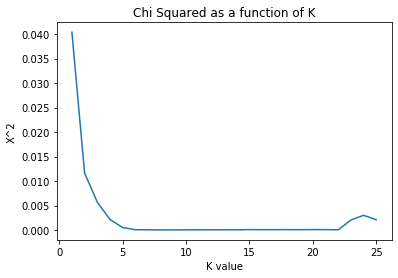

In [34]:
# perform train-test split to designate 20% of the observed points as the cross-validation set
from sklearn.model_selection import train_test_split
train, cv = train_test_split(df, test_size=0.2, random_state=42)

# calculate chi^2 for each K
chi2_vals = []
for K in range(1,26):
    popt = fourier_model(train['phase'], train['mag'], K)
    fitted_cv_vals = fourier(cv['phase'], *popt)
    chi2_vals.append(chi2(fitted_cv_vals, cv['mag']))
    
plt.plot(range(1,26),chi2_vals)
plt.xlabel('K value')
plt.ylabel('X^2')
plt.title('Chi Squared as a function of K')

From this plot, a reasonable K value to use would be in the elbow, which is K=6.

## #8
Predict the expected magnitude of the star at t = 2329.0

In [35]:
# convert back from phase to time by ordering points by the time column
df_time_space = df.sort_values('time')

# find total number of periods
ti = df_time_space['time'][0]
tf = df_time_space['time'][84]

num_periods = (tf-ti)/P
num_periods

641.42305133215

In [36]:
# transform fourier model from phase to time
x,y=fourier_fit(df['phase'], df['mag'], w, P, 6)
mags_time_space = []
for i in range(650):
    for mag in y:
        mags_time_space.append(mag)

In [37]:
# find index of where t=2329.0
approx_index = len(mags_time_space)*(2329 - ti)/(2330-ti)
approx_index

55161.46631611765

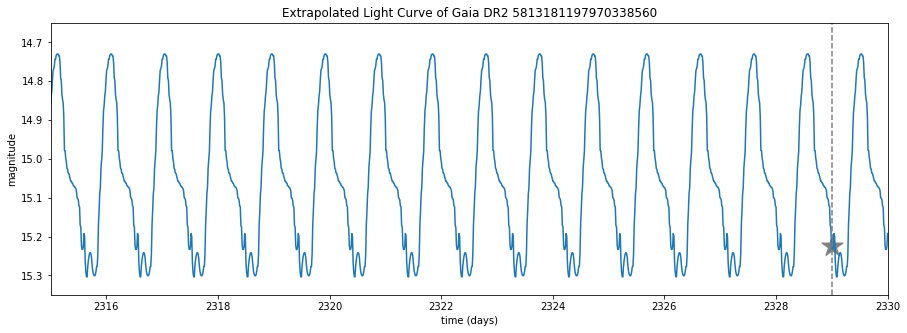

In [38]:
# plot fourier model in time space
plt.figure(figsize=(15,5))
plt.plot(np.linspace(ti,2330,len(mags_time_space)),mags_time_space, label='fitted values')
plt.xlabel('time (days)')
plt.ylabel('magnitude')
plt.xlim(2315,2330)
plt.ylim(15.35,14.65)

# mark where t=2329.0
plt.scatter(2329.0, mags_time_space[55163], marker='*', s=500, color='grey')
plt.axvline(2329.0, color='grey', linestyle='dashed')
plt.title('Extrapolated Light Curve of Gaia DR2 5813181197970338560')
plt.show()

In [39]:
# calculate magnitude when t=2329.0
mags_time_space[55163]

15.2255872368587

The expected magnitude of a star at t=2329.0 is 15.22

## #9
Estimate the mean magnitude using your Fourier model for each of the 100 light curves.

In [40]:
# construct fourier model for each light curve then calculate mean magnitude from it
estimated_mean_mags_fourier = []
for source_id in query['source_id']:
    light_curve = pd.read_csv('anonymous1613329577203/EPOCH_PHOTOMETRY-Gaia DR2 '+str(source_id)+'.csv')
    light_curve = light_curve[light_curve['band'] == 'G']
    
    frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(minimum_frequency=fmin, maximum_frequency=fmax, samples_per_peak=20)
    P = 1/frequency[np.argmax(power)]
    w = 2*np.pi/P
    
    df = pd.DataFrame({'mag': light_curve['mag'], 'flux': light_curve['flux'],'phase' : light_curve['time']%P, 'time' : light_curve['time']})
    df = df.sort_values('phase')
    
    x,y = fourier_fit(df['phase'], df['mag'], P, w, 6)
    
    flux_mean = np.mean(mag_to_flux(y))
    estimated_mean_mags_fourier.append(flux_to_mag(flux_mean))

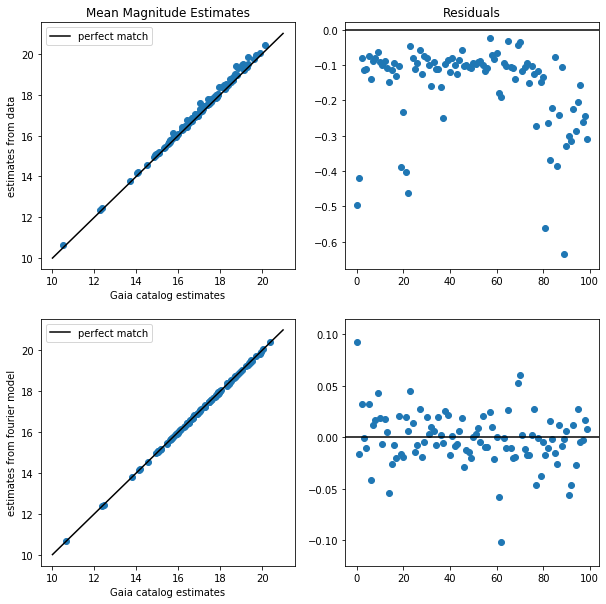

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# plot to compare estimates of the mean G-band magnitude from part (3) to the estimate in the Gaia catalog
axs[0,0].scatter(estimated_mean_mags, query['int_average_g'])
axs[0,0].plot([10,21], [10,21], label='perfect match', c='k')
axs[0,0].set(xlabel='Gaia catalog estimates', ylabel='estimates from data')
axs[0,0].legend()
axs[0,0].set_title('Mean Magnitude Estimates')

# residuals
axs[0,1].scatter(range(100), np.array(estimated_mean_mags) - np.array(query['int_average_g']))
axs[0,1].axhline(0, color='k')
axs[0,1].set_title('Residuals')

# plot to compare estimates of the mean G-band magnitude from part (9) to the estimate in the Gaia catalog
axs[1,0].scatter(estimated_mean_mags_fourier, query['int_average_g'])
axs[1,0].plot([10,21], [10,21], label='perfect match', c='k')
axs[1,0].set(xlabel='Gaia catalog estimates', ylabel='estimates from fourier model')
axs[1,0].legend()

# residuals
axs[1,1].scatter(range(100), np.array(estimated_mean_mags_fourier) - np.array(query['int_average_g']))
axs[1,1].axhline(0, color='k')

plt.show()

The mean magnitide estimates from the data (part 3) seem to be consistently smaller than the estimates from the Gaia catalog. While the mean magnitude estimates from the fourier model (part 9) seem to match up pretty well with the estimates from the Gaia catalog since the residuals are spread around zero.

## #10
Download light curves for the top 3 RR Lyrae in the vari_rrlyrae catalog that have best_classification = “RRc”, mean G-band magnitudes brighter than 15, and more than 80 clean epochs in the G-band. Using a suitable number of terms, compute Fourier expansions for these three light curves. Repeat this for the top 3 RR Lyrae with best_classification = “RRab”.

In [48]:
# query to select RRc
q10 = "SELECT TOP 10 * \
FROM gaiadr2.vari_rrlyrae \
WHERE num_clean_epochs_g >80 \
AND int_average_g > 15 \
AND best_classification = 'RRc'"

query10 = get_gaia_query(q10)

In [49]:
query10

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object
369295551293819386,4659714065019384064,--,--,0.29968072930542267,1.3069604120795778e-06,--,--,--,--,1665.5985459901694,1.8483211402476682e-06,1666.5214156070076,1.8483211402476682e-06,1666.7901759079257,1.8483211402476682e-06,19.36574204041913,0.0014865082973099066,19.261402383215422,0.012175553541431341,19.02625382193137,0.015273645093017074,0.33357291520993826,0.00820038893756943,0.3024922781676409,0.039128065637280766,0.15846737468562822,0.04498620812713386,--,--,0.0872897400429023,0.04972469728433172,--,--,4.857306717923898,1.79098454132409,--,--,123,96,89,--,--,RRc
369295549951641967,413458020354821504,--,--,0.25226545942277095,1.4169938400807002e-07,--,--,--,--,1699.7709459938912,2.003931906441259e-07,1699.7876648490335,2.003931906441259e-07,1699.7862325680476,2.003931906441259e-07,16.15416123834527,0.0002406080168910644,16.54476454609322,0.003877411072691949,15.594526917579651,0.002103222833694047,0.2900602751689547,0.0008133686900824235,0.34270605330614146,0.019701468843291447,0.22335828746191844,0.010073486471289337,0.07998765658165397,0.243931139895547,0.11136832020840874,0.0028652072024443254,0.060828030196978716,0.002032005644945389,4.638899598424466,0.017712973300842087,4.05547439508009,0.047574939421458996,84,74,76,--,--,RRc
369295549951641967,5438044842945235712,--,--,0.32367639610413174,1.8046289952227474e-07,--,--,--,--,1767.1018579490137,2.552130800095741e-07,1790.070616792081,2.552130800095741e-07,1790.0986001438353,2.552130800095741e-07,17.53896095164829,0.00019823339244144203,17.718136558094358,0.001502154825115012,17.044938055759754,0.0016414615949131685,0.4735813741590391,0.0020611091446371185,0.5371585176071392,0.011738809193729723,0.15012645282799042,0.009546472054784311,-1.6218089298203529,0.23879011842452155,0.164007975603807,0.0018986632517216221,0.08951976583828614,0.0018549100757984317,4.675514290254817,0.01734898186075196,3.1126819455422137,0.027026412863549797,83,73,63,--,--,RRc
369295549951641967,5438049722027941376,--,--,0.3776860081013756,1.971446269101749e-07,--,--,--,--,1766.8597335919396,2.788046051253532e-07,1766.8645769507516,2.788046051253532e-07,1789.9038763884082,2.788046051253532e-07,16.609539579608224,0.00012670218369931603,16.823885035164587,0.0006016928687964193,16.184300655550807,0.0017622594851563656,0.3846475479510225,0.0010037307907299743,0.46950493092150936,0.00536055018043908,0.23294008644813857,0.008475749737118999,-1.8337818877385437,0.23896846764844332,0.10991812986476898,0.0017868860065224934,0.07751678459185393,0.001209790054991834,4.914295155069276,0.018168108422059855,3.8547654882970264,0.022738704439038377,91,88,76,--,--,RRc
369295549951641967,6061698519796908416,--,--,0.26024831584297364,2.90744512441906e-07,--,--,--,--,1698.6770638344337,4.111748326808966e-07,1698.6851901919129,4.111748326808966e-07,1698.6860561692797,4.111748326808966e-07,18.400744832035727,0.00022085265040409902,18.72511398832509,0.0024756995617597117,17.925130071723

Top 3 RRc Stars:


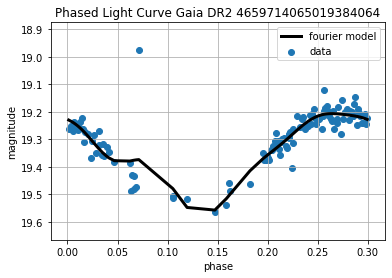

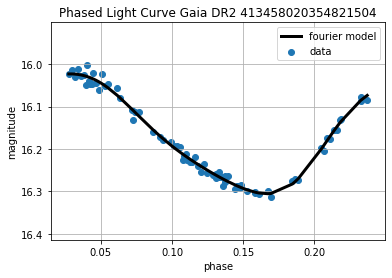

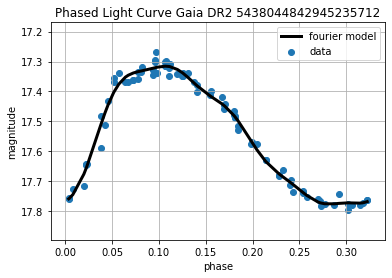

In [54]:
print('Top 3 RRc Stars:')

for source_id in query10['source_id'][:3]:
    light_curve = pd.read_csv('anonymous1613537918861/EPOCH_PHOTOMETRY-Gaia DR2 '+str(source_id)+'.csv')
    frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(nyquist_factor=30)
    light_curve = light_curve[light_curve['band'] == 'G']
    light_curve = light_curve[light_curve['rejected_by_photometry'] == False]
    light_curve = light_curve[light_curve['rejected_by_variability'] == False]
    
    P = 1/frequency[np.argmax(power)]
    w = 2*np.pi/P
    
    df = pd.DataFrame({'mag': light_curve['mag'], 'flux': light_curve['flux'],'phase' : light_curve['time']%P, 'time' : light_curve['time']})
    df = df.sort_values('phase')
    
    x,y = fourier_fit(df['phase'], df['mag'], P, w, 5)
    
    plt.plot(x,y, linewidth=3, color='k', label='fourier model')
    plt.scatter(df['phase'], df['mag'], label='data')
    plt.legend()
    plt.title('Phased Light Curve Gaia DR2 '+str(source_id))
    plt.xlabel('phase')
    plt.ylabel('magnitude')
    plt.legend()
    plt.grid()
    plt.ylim(max(df['mag'])+0.1, min(df['mag'])-0.1)
    plt.show()

In [51]:
q10ab = "SELECT TOP 100 * \
FROM gaiadr2.vari_rrlyrae \
WHERE num_clean_epochs_g > 80 \
AND int_average_g > 15 \
AND best_classification = 'RRab'"

query10ab = get_gaia_query(q10ab)

Top 3 RRab Stars:


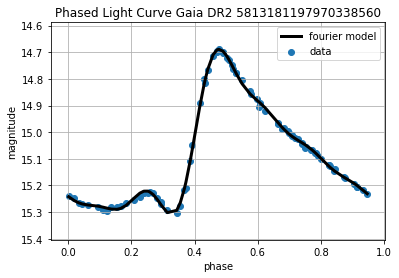

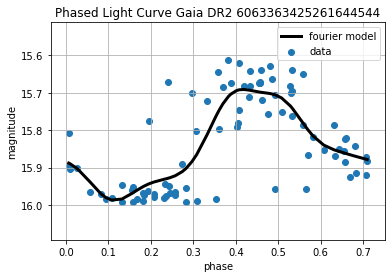

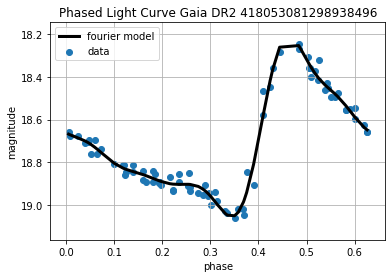

In [56]:
print('Top 3 RRab Stars:')

fmin = 1/np.max(query10ab['pf'])
fmax = 1/np.min(query10ab['pf'])

for source_id in query10ab['source_id'][:3]:
    light_curve = pd.read_csv('anonymous1614966539759/EPOCH_PHOTOMETRY-Gaia DR2 '+str(source_id)+'.csv')
    light_curve = light_curve[light_curve['band'] == 'G']
    light_curve = light_curve[light_curve['rejected_by_photometry'] == False]
    light_curve = light_curve[light_curve['rejected_by_variability'] == False]
    
    frequency, power = LombScargle(light_curve['time'], light_curve['mag']).autopower(nyquist_factor=30, minimum_frequency=fmin, maximum_frequency=fmax)
    
    P = 1/frequency[np.argmax(power)]
    w = 2*np.pi/P
    df = pd.DataFrame({'mag': light_curve['mag'], 'flux': light_curve['flux'],'phase' : light_curve['time'] % P,
                       'time' : light_curve['time']})
    df = df.sort_values('phase')
    
    x,y = fourier_fit(df['phase'], df['mag'], P, w, 6)
    
    plt.plot(x,y, linewidth=3, color='k', label='fourier model')
    plt.scatter(df['phase'], df['mag'], label='data')
    plt.legend()
    plt.title('Phased Light Curve Gaia DR2 '+str(source_id))
    plt.xlabel('phase')
    plt.ylabel('magnitude')
    plt.legend()
    plt.grid()
    plt.ylim(max(df['mag'])+0.1, min(df['mag'])-0.1)
    plt.show()

"RRab variables are the most common, making up 91% of all observed RR Lyrae, and display the steep rises in brightness typical of RR Lyrae. RRc are less common, making up 9% of observed RR Lyrae, and have shorter periods and more sinusoidal variation, and a second bump." - Wikipedia

This matches my models. The models for the RRc stars have more sinusoidal variations and shorter periods while the models for the RRab stars have steeper variations and longer periods than the RRc stars. 

## #11

From the graphs above, the RRc data look as if they are well-described by a single period since the data fairly follow the fourier models. The first and third RRab light curves also look as if they are well-described by a single period. However, the second RRab light curve looks as if there is intrinsic scatter since the data do not follow the fourier models very well (source 6063363425261644544). This star could possible have the Blazhko Effect. The fact that out of the six RRab and RRc stars, one of the RRab stars is possibly effected by Blazhko aligns well with the literature: the Netzel et al. 2018 paper states that "all studies show that the incidence rate of the Blazhko phenomenon is higher for RRab stars than for RRc and can exceed 50 per cent... In RRc stars the reported incidence rates rarely exceed 10 percent." 

## #12

Using Gaia distances to estimate the absolute magnitude of RR Lyraes will only work if there isn’t a lot of dust between us and the RR Lyraes becuase dust causes the flux that we recieve to become reddened (the wavelengths are shifted longer). This will in turn cause the apparent magnitude to be inaccurate. Since absolute magnitude is calculated from apparent magnitude and distance, we will not get an accurate estimate on absolute magnitude.

In [57]:
parallax = 1/4 
parallax

0.25

In [58]:
# query RR Lyrae stars that have accurately measured distances, low parallax errors, not in the disk, and near by
q12 = "SELECT * \
FROM gaiadr2.vari_rrlyrae AS dr2 \
JOIN gaiaedr3.gaia_source AS edr3 \
ON dr2.source_id = edr3.source_id \
WHERE edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND edr3.parallax > 0.25 \
AND pf != 0"

query12 = get_gaia_query(q12)

Source IDs might change between the DR2 and the DR3 catalogs "because the input set of detections grows between processing cycles, inconsistencies between sources cannot always be avoided. It may happen that at a position where we previously had two ‘sources’, we now only have one, or the other way around. We refer to these cases as ‘merge’ and ‘split’, respectively. They lead to the assignment of new source identifiers." (Torra et al. 2020, pg.2)

In [59]:
len(query12)

484

In [63]:
# join changed source ids with gaiaedr3.dr2_neighbourhood catalog
q_matched_ids = "SELECT * \
FROM gaiadr2.vari_rrlyrae AS dr2, gaiaedr3.dr2_neighbourhood AS ids, gaiaedr3.gaia_source AS edr3 \
WHERE dr2.source_id = ids.dr2_source_id AND edr3.source_id = ids.dr3_source_id \
AND edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND edr3.parallax > 0.25 \
AND pf != 0"

query_matched_ids = get_gaia_query(q_matched_ids)  # source id column is matched with dr3 source ids

In [64]:
len(query_matched_ids)

548

In [65]:
len(query_matched_ids[query_matched_ids['dr2_source_id'] != query_matched_ids['dr3_source_id']])

64

There are 64 stars whose source IDs changed.

## #13
Get Bailer-Jones distances which are estimated using our knowledge of Galactic structure to place a prior on the distance inferred from parallaxes.

In [66]:
q13 = "SELECT * \
FROM external.gaiaedr3_distance AS dist, gaiaedr3.dr2_neighbourhood AS ids, \
gaiadr2.vari_rrlyrae AS dr2, gaiaedr3.gaia_source AS edr3 \
WHERE dist.source_id = ids.dr3_source_id \
AND dr2.source_id = ids.dr2_source_id \
AND edr3.source_id = ids.dr3_source_id \
AND edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND edr3.parallax > 0.25 \
AND pf != 0"

query13 = get_gaia_query(q13)

r_med_geo, r_hi_geo, AND r_lo_geo are calculated using their parallaxes and their uncertainties with a 1-dimensional prior over distance. r_med_geo is the posterior median, r_hi_geo is the 84th percentile, and r_low_geo is the 16th percentile. 

The parallax to distance transformation is nonlinear, so small parallax uncertainties can translate to larger distance uncertainties. The probabalistic approach to calculating distance avoids this discrepency in error while simply inverting parallax does not.

## #14
Plot the distribution of targets in Galactic coordinates.

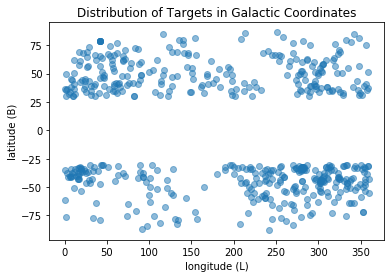

In [69]:
plt.scatter(query_matched_ids['l'], query_matched_ids['b'], alpha=0.5)
plt.title('Distribution of Targets in Galactic Coordinates')
plt.xlabel('longitude (L)')
plt.ylabel('latitude (B)')
plt.show()

From this map, we can confirm that these targets are not in the galactic disk since we can see that abs(B)>30.

In [70]:
df13_sorted = query13.to_pandas().sort_values('source_id')
df_matched_ids_sorted = query_matched_ids.to_pandas().sort_values('source_id')

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


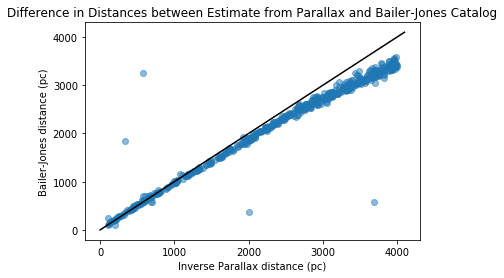

In [71]:
# Compare the distance estimate from the Bailer-Jones catalog to the naive distance estimate from d = 1/parallax

plt.scatter((10**3)/df_matched_ids_sorted['parallax'], df13_sorted['r_med_geo'], alpha=0.5) # units=pc
plt.title('Difference in Distances between Estimate from Parallax and Bailer-Jones Catalog')
plt.ylabel('Bailer-Jones distance (pc)')
plt.xlabel('Inverse Parallax distance (pc)')
plt.plot([0,4100], [0,4100], label='perfect match', c='k')
plt.show()

It seems that the farther away the source is, the distance from inverse parallax is larger than the distance from the Bailer-Jones catalog. 

In [72]:
# query for dr2 parallaxes
q_matched_ids_dr2 = "SELECT * \
FROM gaiadr2.vari_rrlyrae AS vari, gaiadr2.gaia_source AS dr2, gaiaedr3.dr2_neighbourhood AS ids, gaiaedr3.gaia_source AS edr3 \
WHERE dr2.source_id = vari.source_id AND dr2.source_id = ids.dr2_source_id AND edr3.source_id = ids.dr3_source_id \
AND dr2.parallax_over_error > 5 \
AND ABS(dr2.b) > 30 \
AND dr2.parallax > 0.25 \
AND pf != 0"

query_matched_ids_dr2 = get_gaia_query(q_matched_ids_dr2)  # source id column is matched with dr2 source ids

In [73]:
# match up source ids
df_matched_ids_dr2 = query_matched_ids_dr2.to_pandas().sort_values('dr3_source_id')
df_matched_ids_dr2_sorted = df_matched_ids_dr2.sort_values('dr3_source_id')

dr2_vs_dr3 = pd.merge(df_matched_ids_dr2_sorted, df_matched_ids_sorted, how='inner', left_on='dr3_source_id', 
                      right_on='source_id', suffixes=('_dr2', '_dr3'))

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'priam_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'flame_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactives

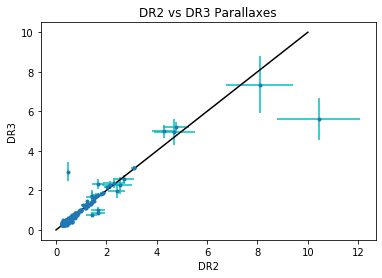

In [74]:
# Plot the DR2 vs DR3 parallaxes

plt.errorbar(dr2_vs_dr3['parallax_dr2'], dr2_vs_dr3['parallax_dr3'], xerr = dr2_vs_dr3['parallax_error_dr2'], 
             yerr = dr2_vs_dr3['parallax_error_dr3'], fmt=".", ecolor='c')
plt.title('DR2 vs DR3 Parallaxes')
plt.ylabel('DR3')
plt.xlabel('DR2')
plt.plot([0,10], [0,10], label='perfect match', c='k')
plt.show()

In [75]:
# calculate ow much smaller the DR3 parallax uncertainties are on average
1 - np.mean(dr2_vs_dr3['parallax_error_dr3']/dr2_vs_dr3['parallax_error_dr2'])

0.3501108480212709

On average, DR3 parallax uncertainties are about 35% smaller than the DR2 parallax uncertainties.

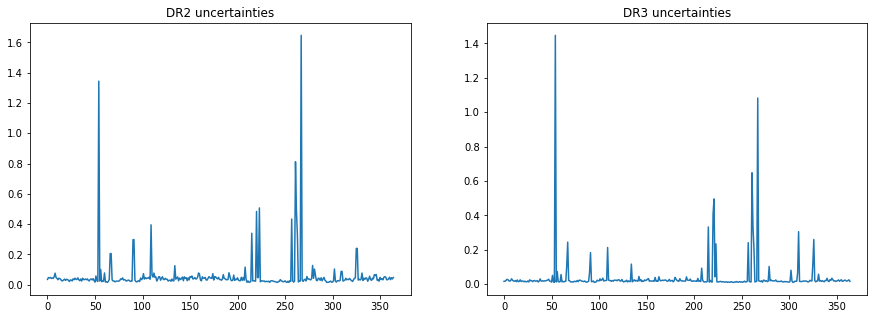

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

#plot dr2 uncertainties
axs[0].plot(dr2_vs_dr3['parallax_error_dr2'])
axs[0].set_title('DR2 uncertainties')

#plot dr3 uncertainties
axs[1].plot(dr2_vs_dr3['parallax_error_dr3'])
axs[1].set_title('DR3 uncertainties')

plt.show()

Both the DR2 and DR3 uncertainties generally consistent within their respective uncertainties. But they do have a decent number of outliers.

Brown et al., 2020 states that "parallax precisions increased by 30 per cent" from DR2 to DR3. This matches up with my analysis very well (DR3 parallax uncertainties are about 35% smaller than the DR2 parallax uncertainties).

## #15
Plot period vs. absolute G-band magnitude for all stars returned in query using the Bailer-Jones distances.

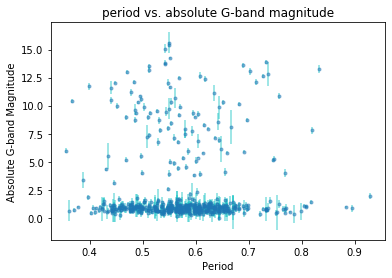

In [88]:
periods = df_matched_ids_sorted['pf'].fillna(df_matched_ids_sorted['p1_o'])

#calculate absolute G-band magnitude
distances = df13_sorted['r_med_geo']
apparent_mag = df_matched_ids_sorted['phot_g_mean_mag']
abs_mag = apparent_mag - 5*np.log10(distances/10)

# calculate error in absolute magnitude from symmetrized distance errors
dist_error = (df13_sorted['r_hi_geo'] - df13_sorted['r_lo_geo'])/2
mag_error = (-5/distances) * dist_error

# plot with error bars
plt.errorbar(periods, abs_mag, yerr=mag_error, alpha=0.5, fmt='.', ecolor='c')
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('period vs. absolute G-band magnitude')
plt.show()

## #16
Apply the quality cuts in Equations C1 and C2 of Lindegren et al. 2018 to the sample, then plot again.

In [85]:
# define quality cut functions

import math
    
def c1(df):
    keep = []
    for i in range(len(df)):
        keep.append(np.sqrt(df.iloc[i]['astrometric_chi2_al'] / (df.iloc[i]['astrometric_n_good_obs_al'] - 5)) < 
                    1.2 * max(1, math.exp(-0.2*df.iloc[i]['phot_g_mean_mag'] - 19.5)))
    return df[keep]

def c1_alt(df):
    df = df[df['astrometric_excess_noise'] < 1]
    return df

def c2(df):
    df = df[df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * df['bp_rp']**2]
    df = df[df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * df['bp_rp']**2]
    return df

In [86]:
# apply cuts

df16 = c1(df13_sorted)
df16 = c2(df13_sorted)

df16_matched_ids = c1_alt(df_matched_ids_sorted)
df16_matched_ids = c2(df_matched_ids_sorted)

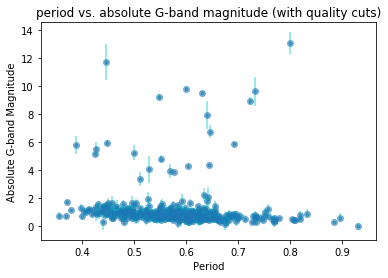

In [89]:
# plot with error bars
df16_sorted = df16.sort_values('source_id')
df16_matched_ids_sorted = df16_matched_ids.sort_values('source_id')

periods16 = df16_matched_ids_sorted['pf'].fillna(df16_matched_ids_sorted['p1_o'])
distances16 = df16_sorted['r_med_geo']
apparent_mag16 = df16_matched_ids_sorted['phot_g_mean_mag']
abs_mag16 = apparent_mag16 - 5*np.log10(distances16/10)

dist_error16 = (df16_sorted['r_hi_geo'] - df16_sorted['r_lo_geo'])/2
mag_error16 = (-5/distances16) * dist_error16

plt.errorbar(periods16, abs_mag16, yerr=mag_error16, alpha=0.5, fmt='.', ecolor='c')

plt.scatter(periods16, abs_mag16, alpha=0.5)
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('period vs. absolute G-band magnitude (with quality cuts)')
plt.show()

There is still scatter, but it has noticably decreased.

## #17

Remove outliers by cutting off objects with absolute G magnitudes greater than 2.

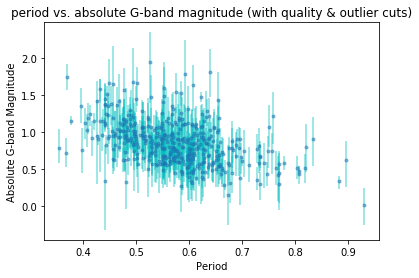

In [257]:
keep = abs_mag16<2

df17_sorted = df16_sorted[keep]
df17_matched_ids_sorted = df16_matched_ids_sorted[keep]

periods17 = df17_matched_ids_sorted['pf']
distances17 = df17_sorted['r_med_geo']
apparent_mag17 = df17_matched_ids_sorted['phot_g_mean_mag']
abs_mag17 = apparent_mag17 - 5*np.log10(distances17/10)

yerr_below = (-5/distances17) * (df17_sorted['r_med_geo'] - df17_sorted['r_lo_geo'])
yerr_above = (-5/distances17) * (df17_sorted['r_hi_geo'] - df17_sorted['r_med_geo'])

plt.errorbar(periods17, abs_mag17, yerr=[yerr_below, yerr_above], alpha=0.5, fmt='.', ecolor='c')
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('period vs. absolute G-band magnitude (with quality & outlier cuts)')
plt.show()

## #18
Plot period-absolute magnitude relation based on Gaia DR2 parallaxes instead of DR3.

In [92]:
# query for dr2 data
q18 = "SELECT * \
FROM external.gaiadr2_geometric_distance AS dist, gaiaedr3.dr2_neighbourhood AS ids, \
gaiadr2.vari_rrlyrae AS dr2, gaiaedr3.gaia_source AS edr3 \
WHERE dist.source_id = ids.dr2_source_id \
AND dr2.source_id = ids.dr2_source_id \
AND edr3.source_id = ids.dr3_source_id \
AND edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND edr3.parallax > 0.25 \
AND pf != 0"
query18 = get_gaia_query(q18)

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


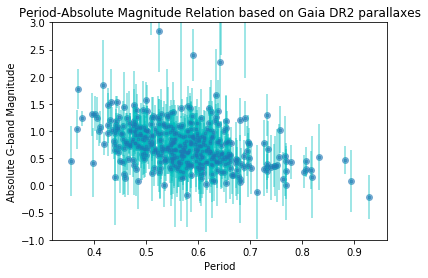

In [93]:
# apply quality cuts
df18 = query18.to_pandas()
df18 = c1_alt(df18)
df18 = c2(df18)

# merge tables
df18_sorted = df18.sort_values('source_id')
df18_merged = df16_matched_ids_sorted.merge(df18_sorted, left_on='dr2_source_id', right_on='source_id', how='right')

# get periods and absolute magnitudes
periods18 = df18_merged['pf_x'] 
distances18 = df18_merged['r_est']
apparent_mag18 = df18_merged['phot_g_mean_mag_x']
abs_mag18 = apparent_mag18 - 5*np.log10(distances18/10)

# calculate error
dist_error18 = (df18_merged['r_hi'] - df18_merged['r_lo'])/2
mag_error18 = (-5/distances18) * dist_error18

# plot
plt.errorbar(periods18, abs_mag18, yerr=mag_error18, alpha=0.5, fmt='.', ecolor='c')

plt.scatter(periods18, abs_mag18, alpha=0.5)
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.ylim(-1,3)
plt.title('Period-Absolute Magnitude Relation based on Gaia DR2 parallaxes')
plt.show()

## #19
Fit a line to the period vs. absolute magnitude relation in the G band, using DR3 data.

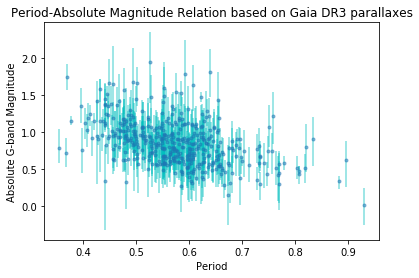

In [94]:
# plot data for EDA
plt.errorbar(periods17, abs_mag17, yerr=[yerr_below, yerr_above], alpha=0.5, fmt='.', ecolor='c')
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period-Absolute Magnitude Relation based on Gaia DR3 parallaxes')
plt.show()

### Model
$M_G = a*log(P/day) + b$
- 2 parameters to fit for: a, b
- $M_G$: absolute magnitude in G-band
- $P$: period (days)
- Error Term: $\sigma_{scatter}$

### Part 1

In [97]:
# define gaussian function
def gaussian(x, sigma, mean):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(mean-x)**2/(2*sigma**2))

In [95]:
# define mh mcmc sampler
def mh_mcmc_sampler(iterations, sigma, mu):
    states = []
    burn_in = int(iterations*0.2)
    current = np.random.uniform(-3*sigma+mu,3*sigma+mu)
    a = 0
    P = []
    for i in range(iterations):
        states.append(current)
        movement = np.random.uniform(-3*sigma+mu,3*sigma+mu)
        
        curr_prob = gaussian(current,sigma, mu)
        move_prob = gaussian(movement,sigma, mu)
        
        acceptance = min(move_prob/curr_prob,1)
        if np.random.uniform(0,1) < acceptance:
            current = movement
            a += 1
        P.append(gaussian(current,sigma, mu))
    return a, P, states[burn_in:]

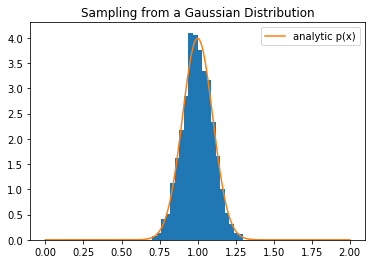

In [98]:
# draw 10,000 from a 1D gaussian distribution
x = np.linspace(0,2,1000)
normal_curve = gaussian(x,0.1, 1)
sample = mh_mcmc_sampler(10000, 0.1, 1)
dist = sample[2]

# plot normalized histogram
plt.hist(dist, density=True, bins=20) 
plt.plot(x, normal_curve, label='analytic p(x)')
plt.legend()
plt.title('Sampling from a Gaussian Distribution')
plt.show()

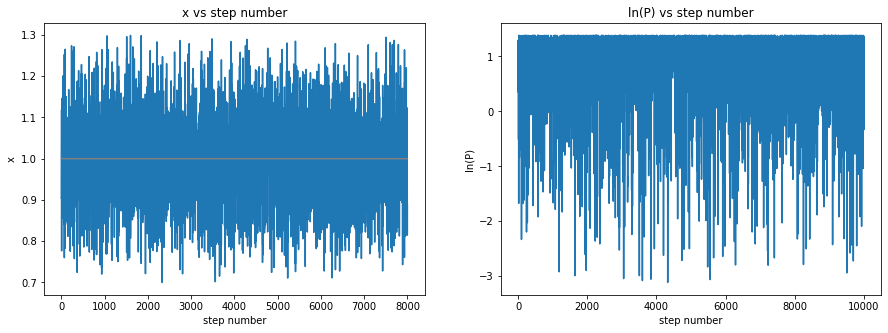

In [102]:
# demonstrate convergance
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(range(8000), dist)
axs[0].plot(np.ones(8000), c='gray')
axs[0].set_title('x vs step number')
axs[0].set(xlabel='step number', ylabel='x')

axs[1].plot(range(10000), np.log(sample[1]))
axs[1].set_title('ln(P) vs step number')
axs[1].set(xlabel='step number', ylabel='ln(P)')

plt.show()

### Likelihood function for a normal distribution:

$ p(\vec{d}\ \mid a, b, \sigma_{scatter}) = \frac{1}{\sqrt{2\pi\sigma_{scatter}^2}} e^{-\frac{(\vec{d} - a \log(P) - b)^2}{2 \sigma_{scatter}^2}}$

where $\vec{d}$ is the data

* log-Likelihood function for a normal distribution:

$ \log(p(\vec{d} \mid a, b, \sigma_{scatter})) = -\frac{1}{2} \sum^{N}_{n=1} \Big(\frac{(\vec{d} - a \log(P) - b)^2}{\sigma_{scatter}^2} + \log(2 \pi \sigma_{scatter}^2) \Big) $

In [272]:
x = np.log(periods17)
y = abs_mag17
yerr = (yerr_below + yerr_above)/2

def ln_likelihood(theta):
    a, b, lns = theta
    y_hat = a * x + b
    s = np.exp(lns)
    s_tot = np.sqrt(yerr**2 + s**2)
    L = -0.5 * (np.log(2*np.pi*s_tot**2) + (y - y_hat)**2/s_tot**2)
    return np.sum(L)

### Prior function:

$ p(a, b, \sigma_{scatter}) $

* Uniformative prior on $a$:

 $$
p(a)=
\begin{cases}
1 \, \rm{if} \, -10 < a < 0\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniformative prior on $b$:

 $$
p(b)=
\begin{cases}
1 \, \rm{if} -5 < b < 5\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniformative prior on $\sigma_{scatter}$:

 $$
P(\sigma_{scatter})=
\begin{cases}
1 \, \rm{if} -10 < \log(\sigma_{scatter}) < 10\\
0 \, {\rm otherwise}\\
\end{cases}
$$

In [104]:
def ln_prior(theta):
    a, b, lns = theta
    prob = 1
    if a<-10 or a>0:
        prob = 0
    if b<-5 or b>5:
        prob = 0
    if lns<-10 and lns>10:
        prob = 0
    return prob

In [173]:
# define proposal function
def proposal(x):
    return x + 0.0001 * np.random.random(3)

In [174]:
# define new mh mcmc sampler that can use my prior, likelihood, and proposal functions
def mh_mcmc_sampler2(iterations, likelihood):
    states = []
    burn_in = int(iterations*0.2)
    current = proposal([-1,-1,-1])
    a = 0
    P = []
    for i in range(iterations):
        states.append(current)
        movement = proposal(current)
        
        curr_posterior = likelihood(current) + ln_prior(current)
        move_posterior = likelihood(movement) + ln_prior(movement)
        
        acceptance = min(move_posterior-curr_posterior,1)
        if np.random.uniform(0,1) < acceptance:
            current = movement
            a += 1
        P.append(likelihood(current))
    return a, P[burn_in:], states[burn_in:]

In [175]:
# draw 10,000 samples
sample = mh_mcmc_sampler2(10000, ln_likelihood)
dist = np.array(sample[2])
lnP = sample[1]
acceptance_fraction = sample[0]/10000

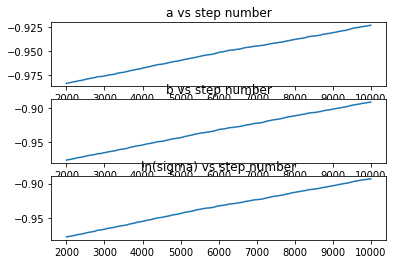

In [176]:
# demonstrate convergance
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(range(2000, 10000), dist[:,0])
#ax1.plot(np.ones(8000), c='gray')
ax1.set_title('a vs step number')

ax2.plot(range(2000, 10000), dist[:,1])
#ax2.plot(np.ones(8000), c='gray')
ax2.set_title('b vs step number')

ax3.plot(range(2000, 10000), dist[:,2])
#ax3.plot(np.ones(8000), c='gray')
ax3.set_title('ln(sigma) vs step number')

plt.show()

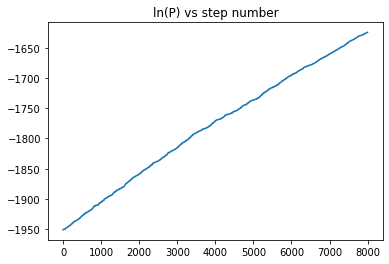

In [177]:
plt.plot(range(8000), lnP)
plt.title('ln(P) vs step number')
plt.show()

In [178]:
print('acceptance fraction:', acceptance_fraction)

acceptance fraction: 0.1769


In [179]:
# !pip install corner
import corner

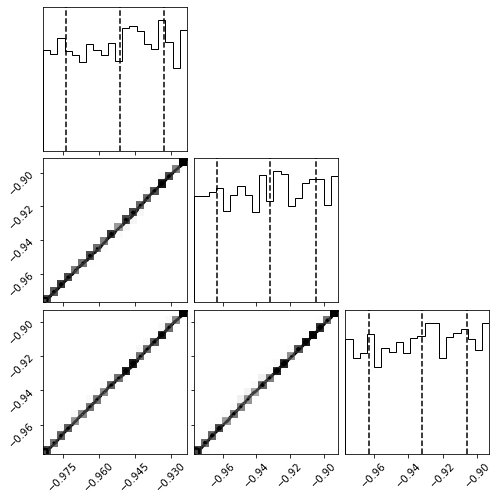

In [180]:
# visualize constraints on the posterior for the fit.

samples = sample[2]

# make the corner plot
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(samples, quantiles=[.16, .50, .84])

# how big is the scatter/typical error in the data?
# let's use the median of logsig for this
# print(f"The typical error in velocity is ~{np.int(np.median(np.exp(trace['logsig'])))} km/s")

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 8000 + 1) instead
  after removing the cwd from sys.path.


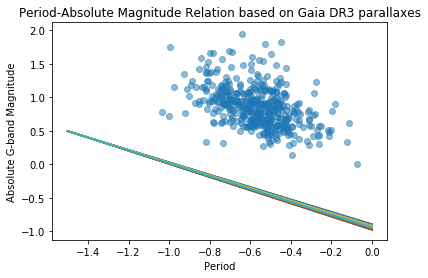

In [181]:
# Plot 50 random, independent samples from the posterior over the data.

x = np.linspace(-1.5,0,1000)
for i in np.random.random_integers(8000, size=50):
    a, b, lns = dist[i]
    plt.plot(x, a*x+b)

plt.scatter(np.log(periods17), abs_mag17, alpha=0.5)
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period-Absolute Magnitude Relation based on Gaia DR3 parallaxes')
#plt.ylim(0,2)
plt.show()    

The spread between samples as a function of period does not seem consistent with the data since the 50 random samples do not go through the data points. 

### Part 2

In [182]:
#!pip install arviz==0.11.1
#!pip install pymc3
import pymc3 as pm
import theano

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:697: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  "DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [273]:
not_null= periods17.notnull()
x = np.log(periods17)[not_null]
y = abs_mag17[not_null]
yerr = yerr[not_null]

In [196]:
def pm_ln_likelihood(theta, y_hat):
    a, b, lns = theta
    s = pm.math.exp(lns)
    s_tot = pm.math.sqrt(yerr**2 + s**2)
    L = -0.5 * (pm.math.log(2*np.pi*pm.math.sqr(s)) + pm.math.sqr((y - y_hat)/s))
    return pm.math.sum(L)

In [197]:
# set up the model (from Lecture 03_MCMC_hubble_example)
with pm.Model():
    
    # define priors
    a = pm.Uniform("a", lower=-10, upper=0)
    b = pm.Uniform("b", lower=-5, upper=5)
    lns = pm.Uniform("lns", lower=-10, upper=10)
    theta = [a,b,lns]
    
    mu = a * x + b
    
    # define the log-likelihood function
    # note that numpy doesn't play nicely with PyMC3, so you should use their built in math functions
    #pm_ln_likelihood(a, b, lns)
    pm.Potential('log likelihood', pm_ln_likelihood(theta, mu))

    # now set up the model to run
    # default of PyMC3 is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=200)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["a", "b", "lns"])
    
    # pm.summary provides some useful summary and convergance statistics
    pm.summary(trace, var_names=["a", "b", "lns"])

TypeError: unsupported operand type(s) for *: 'TransformedRV' and 'SharedVariable'

Part 3

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lns, b, a]


Sampling 2 chains for 200 tune and 1_000 draw iterations (400 + 2_000 draws total) took 5235 seconds.
The acceptance probability does not match the target. It is 0.9648307676553609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9669844865038502, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


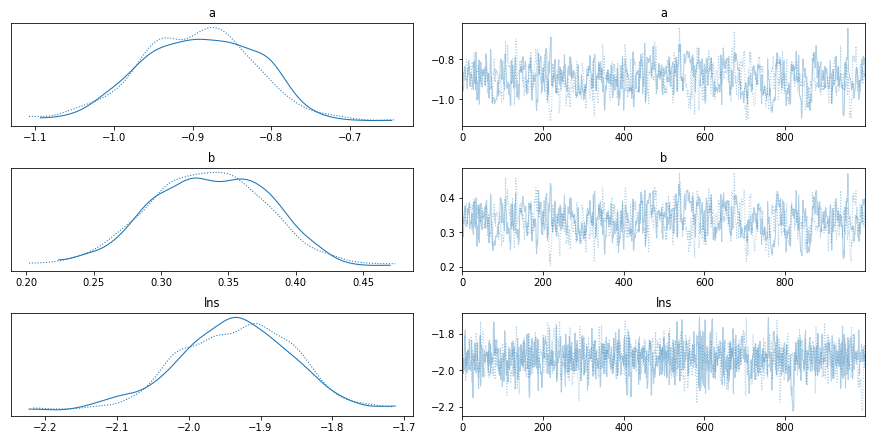

In [143]:
not_null= periods17.notnull()
x = np.log(periods17[not_null])
y = abs_mag17[not_null]
yerr = yerr[not_null]

# set up the model (from Lecture 03_MCMC_hubble_example)
with pm.Model() as model:
    
    # define priors
    a = pm.Uniform("a", lower=-50, upper=50)
    b = pm.Uniform("b", lower=-50, upper=50)
    lns = pm.Uniform("lns", lower=-10, upper=10)
    
    # define the log-likelihood function
    # note that numpy doesn't play nicely with PyMC3, so you should use their built in math functions
    #pm_ln_likelihood(a, b, lns)
    pm.Normal("obs", mu = a*x+b, sd=pm.math.sqrt(pm.math.exp(lns)**2 + yerr**2), observed=y)
    
    step = pm.NUTS()
    # now set up the model to run
    # default of PyMC3 is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=200, chains=2, cores=2, step=step)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["a", "b", "lns"])
    
    # pm.summary provides some useful summary and convergance statistics
    pm.summary(trace, var_names=["a", "b", "lns"])

In [144]:
pm.summary(trace, var_names=["a", "b", "lns"])

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.893,0.072,-1.022,-0.760,0.004,0.003,392.0,389.0,394.0,737.0,1.0
b,0.335,0.043,0.264,0.422,0.002,0.002,388.0,388.0,388.0,624.0,1.0
lns,-1.935,0.080,-2.088,-1.787,0.003,0.002,802.0,781.0,848.0,698.0,1.0


In [260]:
a = -0.893
b = 0.335
s = 10**-1.935

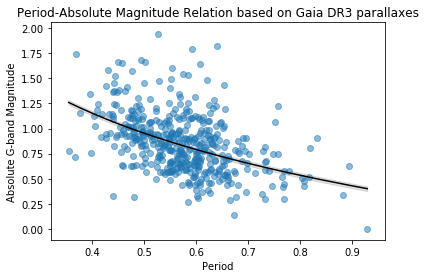

In [261]:
x = periods17.sort_values()
intrinsic_y = a * np.log(x) + b
plt.plot(x, intrinsic_y, label='pymc3 model fit', c='k')
plt.fill_between(x, intrinsic_y - 2*s, intrinsic_y + 2*s,
                 color='dimgray', alpha=0.2)


plt.scatter(periods17, abs_mag17, alpha=0.5, label='observed data')
plt.xlabel('Period')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period-Absolute Magnitude Relation based on Gaia DR3 parallaxes')
plt.show()

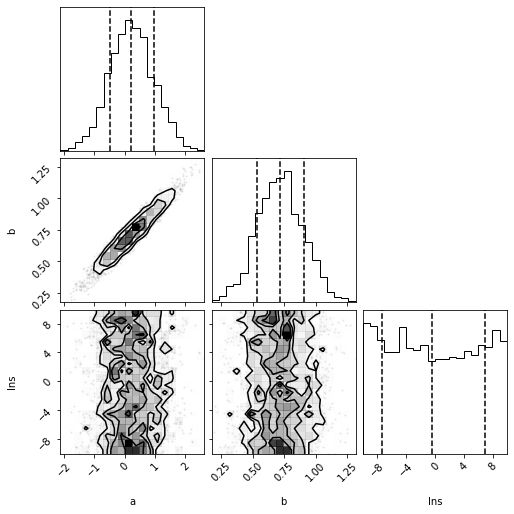

In [262]:
samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "lns"])

# make the corner plot and plot results from Hubble's paper as 'truth'
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(samples, quantiles=[.16, .50, .84])

In [186]:
# Note: I only drew 1,000 samples instead of 10,000 becuase my computer took unusually long to run the pymc3 model

## #20
Cross-match your sample of clean RR-Lyrae stars with WISE.

In [198]:
q20 = "SELECT * \
FROM external.gaiaedr3_distance AS dist, gaiaedr3.dr2_neighbourhood AS ids, \
gaiadr2.vari_rrlyrae AS dr2, gaiaedr3.gaia_source AS edr3, \
gaiadr2.allwise_best_neighbour AS wise2, gaiadr1.allwise_original_valid AS wise1 \
WHERE dist.source_id = ids.dr3_source_id \
AND dr2.source_id = ids.dr2_source_id \
AND edr3.source_id = ids.dr3_source_id \
AND edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND edr3.parallax > 0.25 \
AND wise2.allwise_oid = wise1.allwise_oid \
AND wise2.source_id = dr2.source_id"

query20 = get_gaia_query(q20)

In [199]:
df20 = query20.to_pandas()

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site

In [200]:
# apply quality cuts
df20 = c1_alt(df20)
df20 = c2(df20)

## #21
Repeat step (19iii), now using the WISE “W2” magnitude rather than the G band.

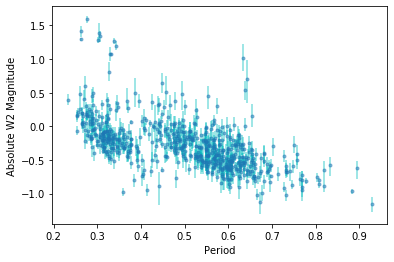

In [274]:
periods21 = df20['pf'].fillna(df20['p1_o'])
distances21 = (df20['r_hi_geo'] + df20['r_lo_geo'])/2
apparent_mag21 = df20['w2mpro']
abs_mag21 = apparent_mag21 - 5*np.log10(distances21/10)

keep = abs_mag21<2

yerr_below = (-2.1715/distances21[keep]) * (df20['r_med_geo'][keep] - df20['r_lo_geo'][keep])
yerr_above = (-2.1715/distances21[keep]) * (df20['r_hi_geo'][keep] - df20['r_med_geo'][keep])

plt.errorbar(periods21[keep], abs_mag21[keep], yerr=[yerr_below, yerr_above], alpha=0.5, fmt='.', ecolor='c')
plt.xlabel('Period')
plt.ylabel('Absolute W2 Magnitude')
plt.show()

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lns, b, a]


Sampling 2 chains for 200 tune and 1_000 draw iterations (400 + 2_000 draws total) took 14181 seconds.
The acceptance probability does not match the target. It is 0.9226325285881636, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9205510119498235, but should be close to 0.8. Try to increase the number of tuning steps.


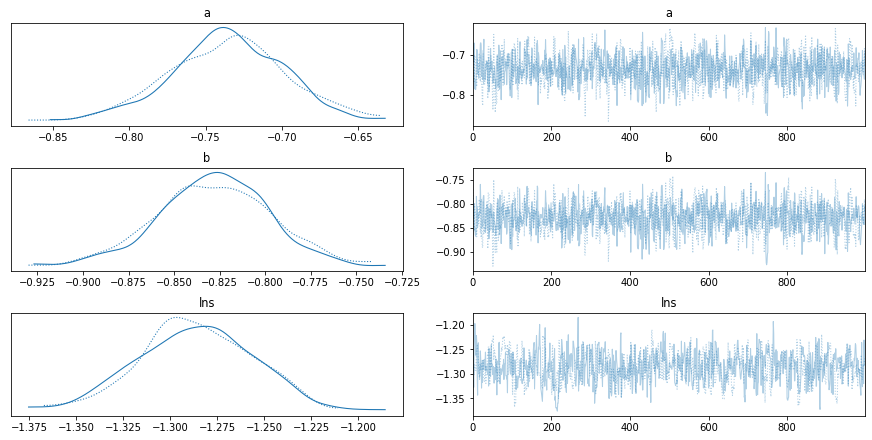

In [151]:
x = periods21[keep]
y = abs_mag21[keep]
yerr = (yerr_below + yerr_above)/2

# set up the model (from Lecture 03_MCMC_hubble_example)
with pm.Model() as model:
    
    # define priors
    a = pm.Uniform("a", lower=-50, upper=50)
    b = pm.Uniform("b", lower=-50, upper=50)
    lns = pm.Uniform("lns", lower=-10, upper=10)
    
    # define the log-likelihood function
    # note that numpy doesn't play nicely with PyMC3, so you should use their built in math functions
    #pm_ln_likelihood(a, b, lns)
    pm.Normal("obs", mu = a*pm.math.log(x)+b, sd=pm.math.sqrt(pm.math.exp(lns)**2 + yerr**2), observed=y)

    # now set up the model to run
    # default of PyMC3 is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=200)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["a", "b", "lns"])
    
    # pm.summary provides some useful summary and convergance statistics
    pm.summary(trace, var_names=["a", "b", "lns"])

In [152]:
pm.summary(trace, var_names=["a", "b", "lns"])

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.736,0.037,-0.803,-0.661,0.001,0.001,1018.0,1004.0,1036.0,1014.0,1.0
b,-0.828,0.030,-0.884,-0.769,0.001,0.001,1056.0,1048.0,1064.0,1045.0,1.0
lns,-1.286,0.030,-1.340,-1.231,0.001,0.001,601.0,599.0,605.0,619.0,1.0


In [275]:
a = -0.736
b = -0.828
s = 10**-1.286

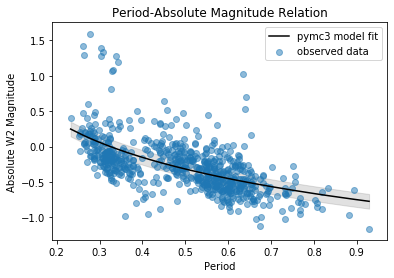

In [276]:
x = periods21[keep]
y = abs_mag21[keep]
yerr = (yerr_below + yerr_above)/2

x = periods21[keep].sort_values()
intrinsic_y = a * np.log(x) + b
plt.plot(x, intrinsic_y, label='pymc3 model fit', c='k')
plt.fill_between(x, intrinsic_y - 2*s, intrinsic_y + 2*s,
                 color='dimgray', alpha=0.2)

plt.scatter(periods21[keep], abs_mag21[keep], alpha=0.5, label='observed data')
plt.xlabel('Period')
plt.ylabel('Absolute W2 Magnitude')
plt.title('Period-Absolute Magnitude Relation')
plt.legend()
plt.show()

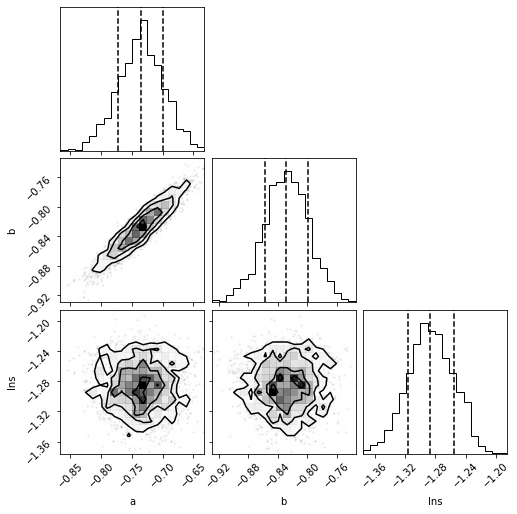

In [154]:
samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "lns"])

# make the corner plot and plot results from Hubble's paper as 'truth'
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(samples, quantiles=[.16, .50, .84])

## #22

In the optical (G-band) the inferred correlation between period and luminoscity is weak since the slope of the line ($a$) is close to zero. In the near-infrared (W2) the inferred correlation between period and luminoscity is stronger since the slope of the line ($a$) is farther from zero. Thus, the period-luminosity relationship is steeper in the near-infrared. 

## #23

Klein & Bloom 2014 V-band (comparable to G-band): $b = 0.4319 ± 0.0184$,   $a = −0.4091 ± 0.2370$,   $\sigma_{intrinsic} = 0.0320 ± 0.0079$

My G-band values: $b = 0.335$,   $a = −0.893$,   $\sigma_{intrinsic} = 0.0116$

Klein & Bloom 2014 W2: $b = −0.4583 ± 0.0112$,   $a = −2.2337 ± 0.1249$,   $\sigma_{intrinsic} = 0.0055 ± 0.0018$

My W2 values: $b = -0.828$,   $a = −0.736$,   $\sigma_{intrinsic} = 0.0518$

The differences between my results and the literature might be due to the systematic difference that I have not accounted for extinction yet, while Klein & Bloom 2014 did account for extinction. 

## #24
Derive a period-color relation for RR Lyrae stars in the Gaia bands, between log(period) and the Gaia GBP − GRP color.

In [280]:
df24 = query13.to_pandas()

keep = df24['bp_rp'].notnull()
y = df24['bp_rp'][keep]
x = df24['pf'][keep]
yerr = (df24['int_average_bp_error'] - df24['int_average_rp_error'])[keep]

keep2 = yerr.notnull()
y = y[keep2]
x = x[keep2]
yerr = yerr[keep2]

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [235]:
with pm.Model() as model:
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-5, upper=5)
    lns = pm.Uniform('lns', lower=-10, upper=10)
    
    pm.Normal('obs', mu= a*np.log10(x)+b, sd=np.exp(yerr), observed=y)
    
    step = pm.NUTS()
    
    trace = pm.sample(draws=1000, tune=200, chains=2, cores=2, step=step)
    

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lns, b, a]


Sampling 2 chains for 200 tune and 1_000 draw iterations (400 + 2_000 draws total) took 1196 seconds.
The acceptance probability does not match the target. It is 0.903366888861307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9226435848664089, but should be close to 0.8. Try to increase the number of tuning steps.


KeyError: 'var names: "[\'obs\'] are not present" in dataset'

In [236]:
pm.summary(trace, var_names=['a', 'b', 'lns'])

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.228,0.729,-1.115,1.613,0.031,0.022,563.0,563.0,565.0,479.0,1.0
b,0.717,0.183,0.393,1.074,0.008,0.006,567.0,514.0,567.0,784.0,1.0
lns,-0.225,5.938,-9.201,9.558,0.188,0.160,997.0,688.0,908.0,860.0,1.0


In [281]:
a = 0.228
b = 0.717
s = -0.225

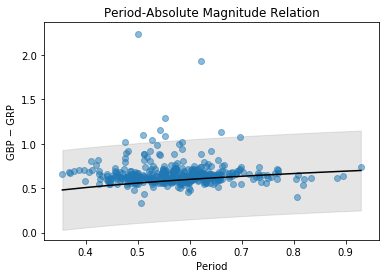

In [282]:
x = x.sort_values()
intrinsic_y = a * np.log(x) + b
plt.plot(x, intrinsic_y, label='pymc3 model fit', c='k')
plt.fill_between(x, intrinsic_y - 2*s, intrinsic_y + 2*s,
                 color='gray', alpha=0.2)

plt.scatter(x, y, alpha=0.5, label='observed data')
plt.xlabel('Period')
plt.ylabel('GBP − GRP')
plt.title('Period-Absolute Magnitude Relation')
plt.show()

## #25
Write an ADQL query to download the full Gaia RR Lyrae catalog (i.e., no longer excluding stars with imprecise parallaxes or low galactic latitude) and cross-match it with the Gaia source catalog.

In [284]:
q25 = "SELECT * \
FROM gaiadr2.vari_rrlyrae AS dr2 \
INNER JOIN gaiaedr3.dr2_neighbourhood AS ids \
ON dr2.source_id = ids.dr2_source_id \
INNER JOIN gaiaedr3.gaia_source AS dr3 \
ON dr3.source_id = ids.dr3_source_id"

query25 = get_gaia_query(q25)

## #26
Calculate the color excess

In [285]:
df25 = query25.to_pandas()

observed = df25['bp_rp']
periods = df25['pf'] #.fillna(df25['p1_o'])
intrinsic = a * np.log(periods) + b 

g_extinction = 2.0 * (observed - intrinsic)

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Jackie/opt/anaconda3/lib/python3.7/site

## #27
Compare calculated AG values to the “G_absorption” value provided in the RR Lyrae catalog.

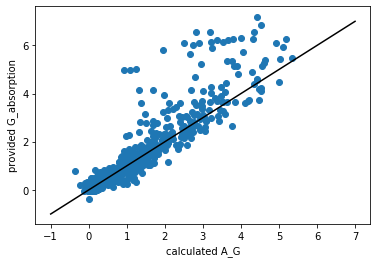

In [286]:
plt.scatter(g_extinction, df25['g_absorption'])
plt.plot([-1,7], [-1,7], label='perfect match', c='k')
plt.xlabel('calculated A_G')
plt.ylabel('provided G_absorption')
plt.show()

## #28
Plot a 2-d map of E (GBP − GRP ) as a function of Galactic longitude and latitude

Map of E(GBP − GRP )


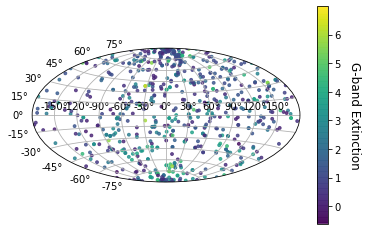

In [304]:
print('Map of E(GBP − GRP )')

plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(df25['l'], df25['b'], alpha=0.8, c=g_extinction, s=8)
cb = plt.colorbar()
cb.set_label("G-band Extinction", rotation=270, labelpad=20, fontsize=12)
plt.show()

## #29

In [320]:
# !pip install dustmaps
import dustmaps
from dustmaps.sfd import SFDQuery

import astropy.units as units
from astropy.coordinates import SkyCoord

In [312]:
dustmaps.sfd.fetch()

 64.0 MiB of 64.0 MiB |   5.5 MiB/s |###################| 100% | ETA:  00:00:00

 63.8 MiB of 64.0 MiB |   6.0 MiB/s |################## |  99% | ETA:   0:00:00

In [313]:
sfd = SFDQuery()

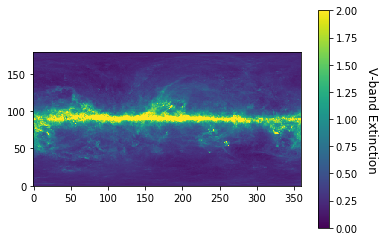

In [333]:
# code adapted from https://dustmaps.readthedocs.io/en/latest/examples.html

l = np.arange(-180,180)
b = np.arange(-90, 90)
l, b = np.meshgrid(l, b)
coords = SkyCoord(l*units.deg, b*units.deg, distance=1.*units.kpc, frame='galactic')

# convert SFD reddenings to magnitudes of Av.
Av_sfd = 2.742 * sfd(coords)

plt.imshow(np.sqrt(Av_sfd)[::,::-1], vmin=0., vmax=2., origin='lower', interpolation='nearest', aspect='equal')
cb = plt.colorbar()
cb.set_label("V-band Extinction", rotation=270, labelpad=20, fontsize=12)
plt.show()

## #30
I would not expect my map to look exactly like SFD becuase the SFD map was constructed from maps of the diffuse background radiation and imaging of the sky in photometric bands. The SFD map measured dust tempurature while my map measures the extinction. 